In [2]:
### Preparing the data
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = pd.read_csv('Data/training_data.csv')
data.head()

# Update binary variables to 0 and 1
binary_vars = ['targets_emissions', 'verification_co2directscope1', 'sbti_alignment', 'nz_statement', 'policy_emissions']
data[binary_vars] = data[binary_vars].replace({100: 1, 1: 0})

# DF with binary variables and country code
X_with_country = data[['verification_co2directscope1', 'targets_emissions', 'policy_emissions', 'sbti_alignment', 'nz_statement', 'country_code']]
X_with_country = X_with_country.dropna() # Remove NANs

# DF with binary variables and industry name
X_with_ind = data[['verification_co2directscope1', 'targets_emissions', 'policy_emissions', 'sbti_alignment', 'nz_statement', 'clarity_industry_name']]
X_with_ind = X_with_ind.dropna() # Remove NANs

# DF with binary variables, country code, and industry name
X_with_country_and_ind = data[['verification_co2directscope1', 'targets_emissions', 'policy_emissions', 'sbti_alignment', 'nz_statement', 'country_code', 'clarity_industry_name']]
X_with_country_and_ind = X_with_country_and_ind.dropna()

# Isolate a df with only binary variables (no country, no industry)
X = X_with_country.drop(columns=['country_code']) 

# Create dependent variable df for feature analysis (comment accordingly)
y = data['co2directscope1_intensity']
# y = data['co2directscope1_raw']
# y = data['revenue']

y = y.dropna() # Remove NANs
y = y[X.index] # Ensure y and X are aligned after dropping NANs

# Split the data (without country code) into 80% training and 20% testing sets
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
### Lasso with only binary variables

import matplotlib.pyplot as plt

# Fit the Lasso Regression model
lasso = Lasso(alpha=1.0)  
lasso.fit(X_train, y_train) 

# Predict on the test set
y_pred = lasso.predict(X_test) 

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error: ', mse)
print('R-squared:', r2)

# Print the coefficients
coef = pd.Series(lasso.coef_, index=X.columns)
print('Lasso Coefficients:', coef)

Mean Squared Error:  475705.0100843248
R-squared: 0.006850605588793468
Lasso Coefficients: verification_co2directscope1    145.897354
targets_emissions              -181.172177
policy_emissions                -44.340887
sbti_alignment                 -102.062507
nz_statement                    -30.231106
dtype: float64


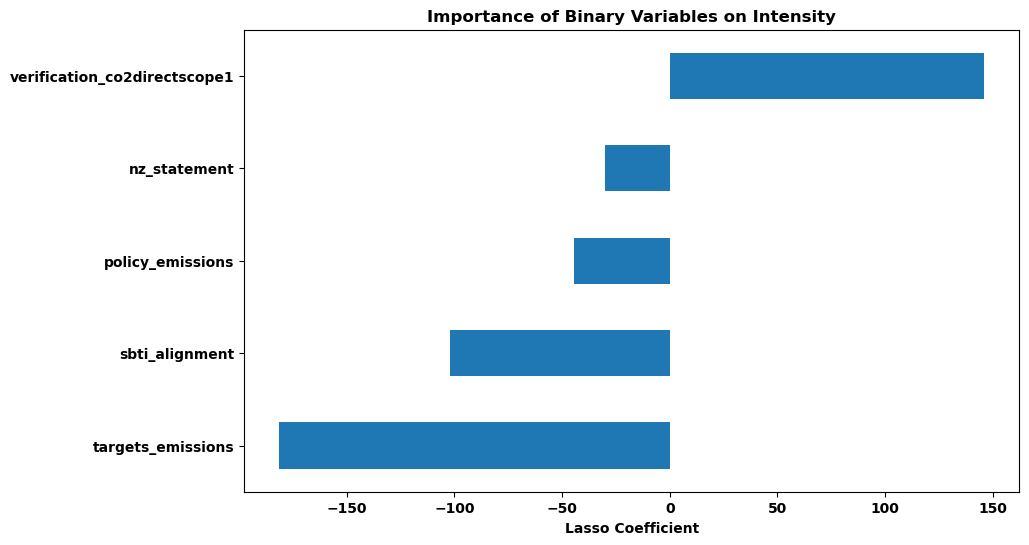

In [4]:
plt.figure(figsize=(10, 6))
coef.sort_values().plot(kind='barh')
plt.xlabel('Lasso Coefficient')
plt.title('Importance of Binary Variables on Intensity')
plt.show()

Mean Squared Error:  463099.5642993645
R-squared: 0.03316752591174199
Random Forest Feature Importances: verification_co2directscope1    0.244650
targets_emissions               0.124198
policy_emissions                0.208265
sbti_alignment                  0.160934
nz_statement                    0.261953
dtype: float64


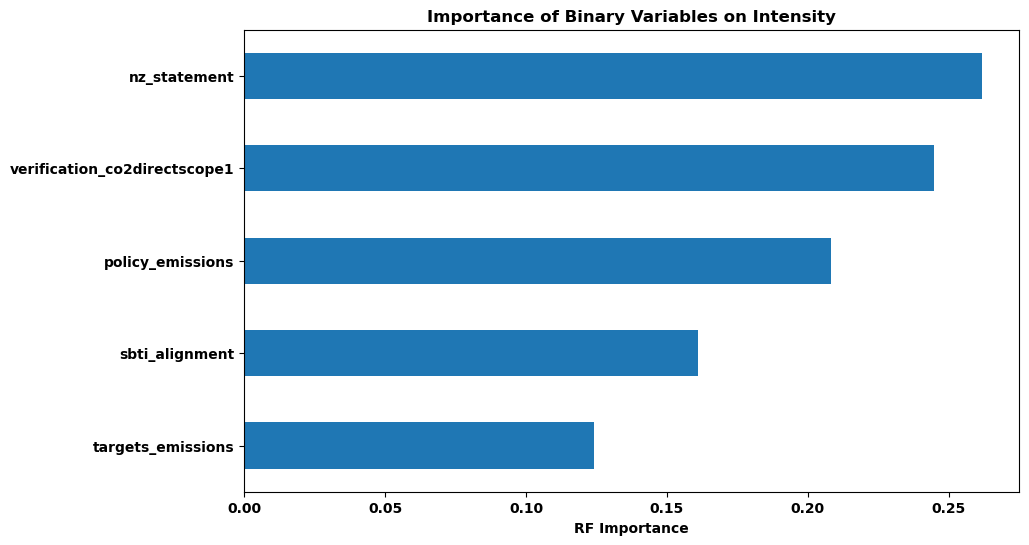

In [5]:
### Random Forest with only binary variables
from sklearn.ensemble import RandomForestRegressor

# Fit Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict on test set
y_pred = random_forest.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error: ', mse)
print('R-squared:', r2)

# Print feature importances
feature_importances = pd.Series(random_forest.feature_importances_, index=X.columns)
print('Random Forest Feature Importances:', feature_importances)

# Visualize the feature importance
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh')
plt.xlabel('RF Importance')
plt.title('Importance of Binary Variables on Intensity')
plt.show()

In [6]:
### Lasso with binary variables and country code
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding country_code as separate columns of binary indicators
# Note: Some country codes may be missing due to rows with NANs dropped in previous data prep steps. 
X_encoded = pd.get_dummies(X_with_country, columns=['country_code'], drop_first=True).astype(int)

# Split into training and testing sets
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit and evaluate Lasso model
lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print('Mean Squared Error (Lasso): ', mse_lasso)
print('R-squared (Lasso):', r2_lasso)
print('Total number of features:', len(X_encoded.columns))
print('Number of features selected by Lasso:', sum(lasso.coef_ != 0))

Mean Squared Error (Lasso):  369821.85622266197
R-squared (Lasso): 0.22790732752119114
Total number of features: 44
Number of features selected by Lasso: 25


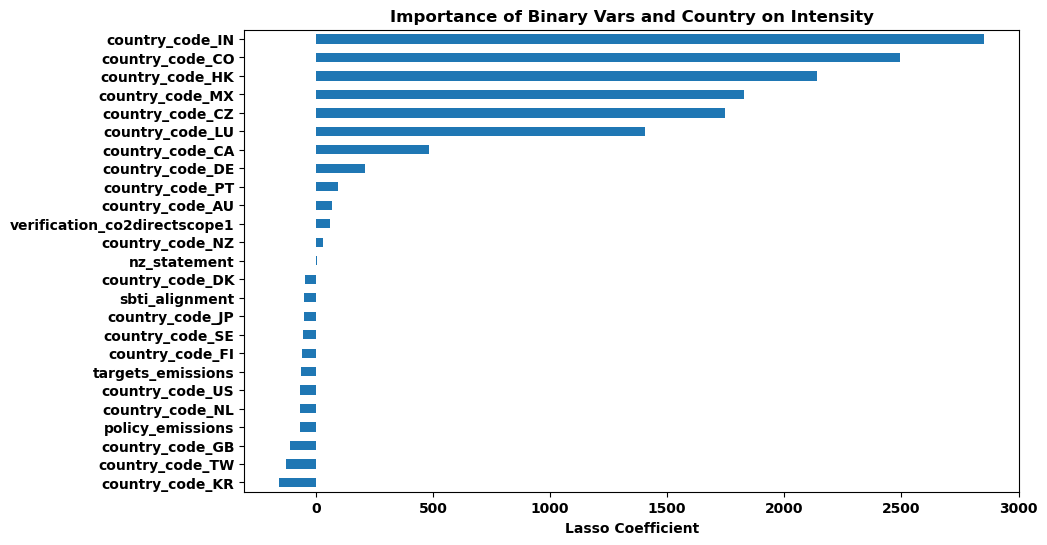

In [7]:
# Visualize feature importance
coef_lasso = pd.Series(lasso.coef_, index=X_encoded.columns)
coef_lasso_nonzero = coef_lasso[coef_lasso != 0] # Filter out variables with a Lasso coefficient of 0

plt.figure(figsize=(10, 6))
coef_lasso_nonzero.sort_values().plot(kind='barh')
plt.xlabel('Lasso Coefficient')
plt.title('Importance of Binary Vars and Country on Intensity')
plt.show()

In [8]:
### Random Forest with country code

# Fit and evaluate Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Mean Squared Error (RF): ', mse_rf)
print('R-squared (RF):', r2_rf)

Mean Squared Error (RF):  303944.7154244325
R-squared (RF): 0.3654418102412824


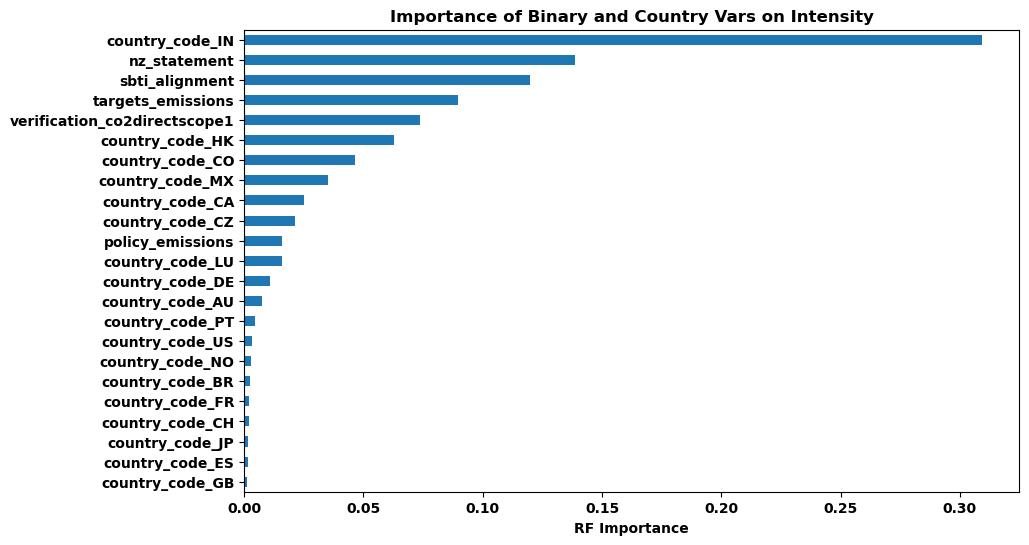

In [9]:
# Visualize Random Forest feature importance
feature_importances_rf = pd.Series(rf.feature_importances_, index=X_encoded.columns)
feature_importances_rf_nonzero = feature_importances_rf[feature_importances_rf > 0.001] # Filter out very small RF values

plt.figure(figsize=(10, 6))
feature_importances_rf_nonzero.sort_values().plot(kind='barh')
plt.xlabel('RF Importance')
plt.title('Importance of Binary and Country Vars on Intensity')
plt.show()

In [10]:
### Lasso with country code and industry

# One-hot encoding country_code as separate columns of binary indicators
# Note: Some country codes may be missing due to rows with NANs dropped in previous data prep steps. 
X_encoded = pd.get_dummies(X_with_country_and_ind, columns=['country_code', 'clarity_industry_name'], drop_first=True).astype(int)

# Split into training and testing sets
random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Fit and evaluate Lasso model
lasso = Lasso(alpha=1.0, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print('Mean Squared Error (Lasso): ', mse_lasso)
print('R-squared (Lasso):', r2_lasso)
print('Total number of features:', len(X_encoded.columns))  # Added line
print('Number of features selected by Lasso:', sum(lasso.coef_ != 0))

Mean Squared Error (Lasso):  173252.40269522349
R-squared (Lasso): 0.638293658528955
Total number of features: 175
Number of features selected by Lasso: 55


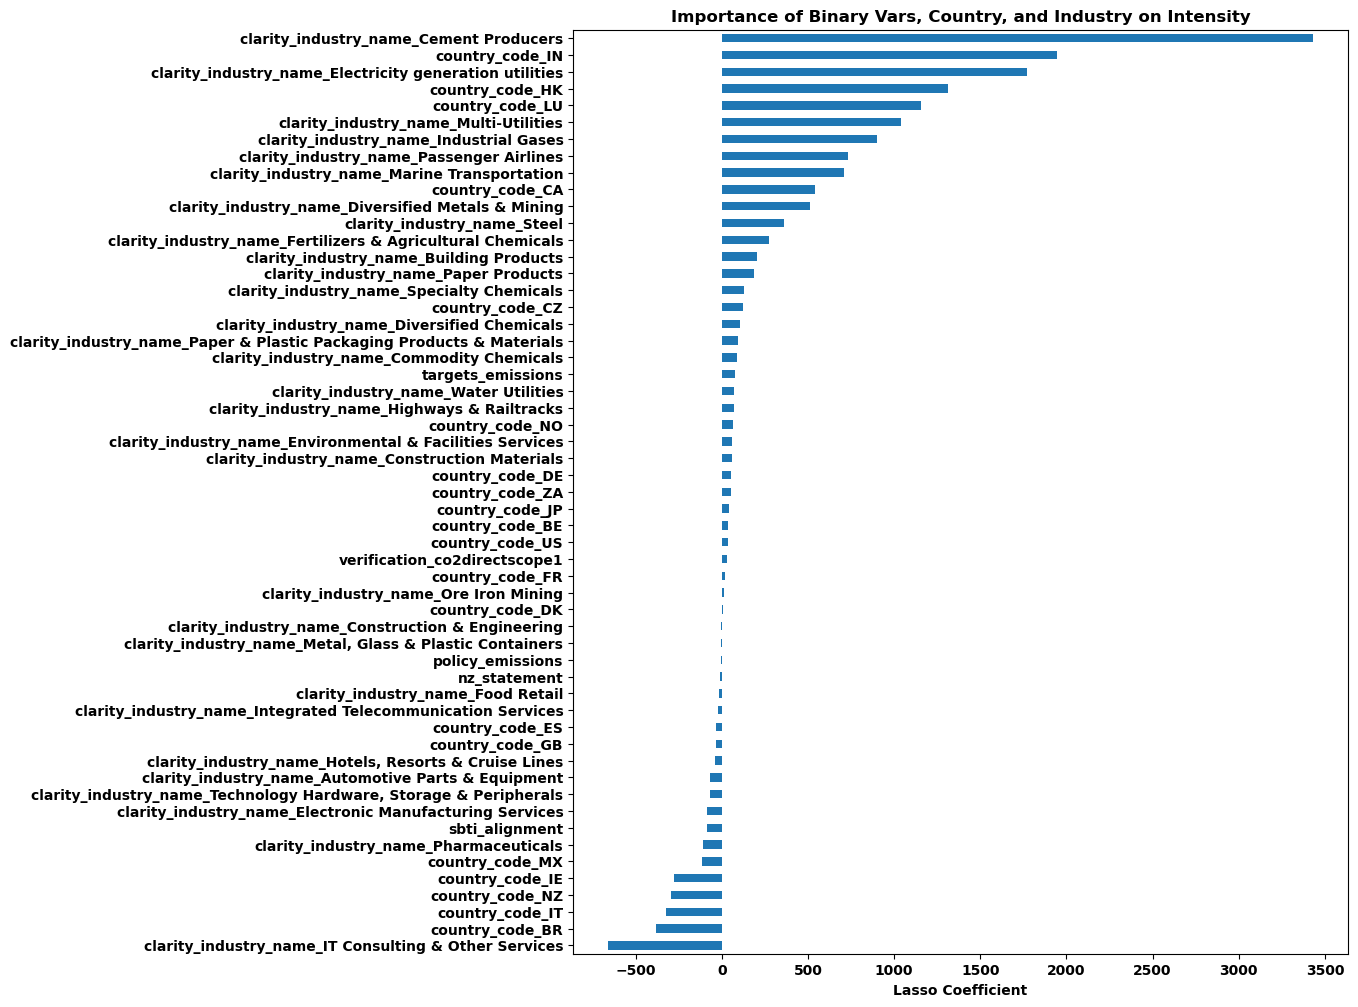

In [11]:
# Visualize feature importance
coef_lasso = pd.Series(lasso.coef_, index=X_encoded.columns)
coef_lasso_nonzero = coef_lasso[coef_lasso != 0] # Filter out variables with a Lasso coefficient of 0

plt.figure(figsize=(10, 12))
coef_lasso_nonzero.sort_values().plot(kind='barh')
plt.xlabel('Lasso Coefficient')
plt.title('Importance of Binary Vars, Country, and Industry on Intensity')
plt.show()

In [12]:
### Random Forest with country code and industry

# Fit and evaluate Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print('Mean Squared Error (RF): ', mse_rf)
print('R-squared (RF):', r2_rf)

Mean Squared Error (RF):  100013.95751774542
R-squared (RF): 0.7911966465860645


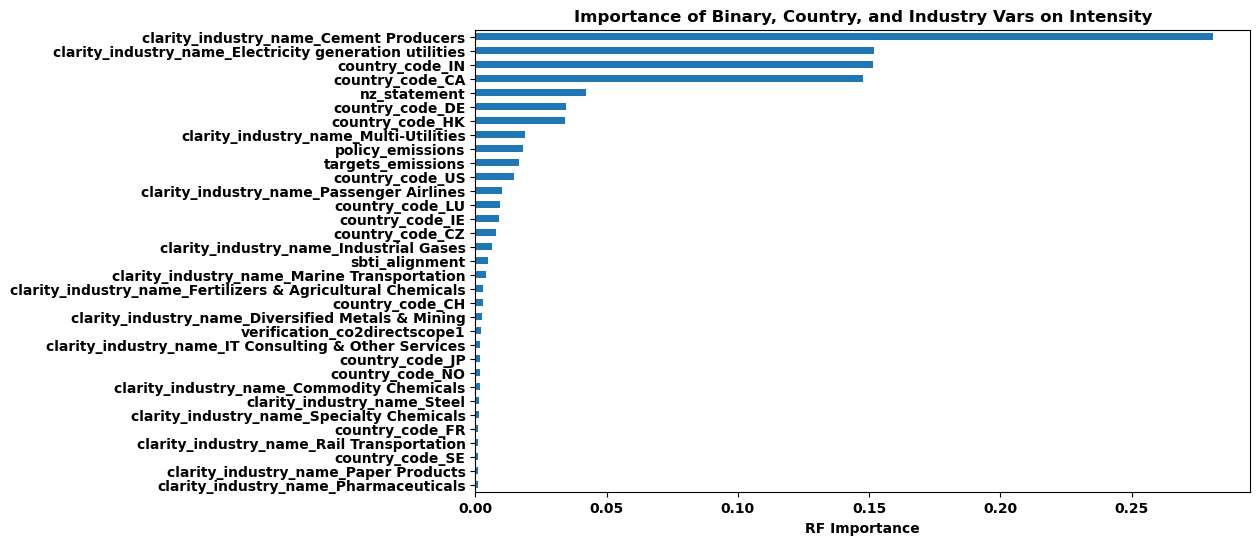

In [13]:
# Visualize Random Forest feature importance
feature_importances_rf = pd.Series(rf.feature_importances_, index=X_encoded.columns)
feature_importances_rf_nonzero = feature_importances_rf[feature_importances_rf > 0.001] # Filter out very small RF values

plt.figure(figsize=(10, 6))
feature_importances_rf_nonzero.sort_values().plot(kind='barh')
plt.xlabel('RF Importance')
plt.title('Importance of Binary, Country, and Industry Vars on Intensity')
plt.show()